# 对比两个模型在Q mean的拟合精度

## 导入依赖

In [6]:
import json
import os
import sys
import pickle

import numpy as np
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
sys.path.append(os.getenv("PROJ_PATH")) # type: ignore

from dmg.core.post.plot_baseflowindex_scatter import \
    plot_baseflow_scatter  # noqa
from project.better_estimate import load_config  # noqa

## 读取并计算两个模型的Runoff

In [25]:
lstm_config = load_config(r"conf/config_dhbv_lstm.yaml")
hopev1_config = load_config(r"conf/config_dhbv_hopev1.yaml")
lstm_out_path = lstm_config["out_path"]
hopev1_out_path = hopev1_config["out_path"]

lstm_flow = np.load(
    os.path.join(lstm_out_path, "streamflow.npy"), allow_pickle=True
)
hopev1_flow = np.load(
    os.path.join(hopev1_out_path, "streamflow.npy"), allow_pickle=True
)

lstm_qmean = lstm_flow.sum(axis=0)[:, 0]
hopev1_qmean = hopev1_flow.sum(axis=0)[:, 0]

print("LSTM GWFlow sample:", lstm_qmean.shape)
print("Hope GWFlow sample:", hopev1_qmean.shape)


q33_obs = np.quantile(lstm_flow, 0.67, axis=0) # 结果 shape: (N,)
q66_obs = np.quantile(lstm_flow, 0.34, axis=0) # 结果 shape: (N,)

slope_fdc_sim = ((np.log(q33_obs) - np.log(q66_obs)) / (0.66 - 0.33))[:,0]
print("Slope FDC sample:", slope_fdc_sim.shape)

LSTM GWFlow sample: (531,)
Hope GWFlow sample: (531,)
Slope FDC sample: (531,)


## 读取流域的降雨

In [9]:
from dmg.core.data.loaders import HydroLoader  # noqa

loader = HydroLoader(lstm_config, test_split=True, overwrite=False) # type: ignore
loader.load_dataset()
eval_dataset = loader.eval_dataset


dict_keys(['x_phy', 'c_phy', 'x_nn', 'c_nn', 'x_nn_norm', 'xc_nn_norm', 'c_nn_norm', 'target'])


In [18]:
forcing_data = eval_dataset['x_phy'].detach().cpu().numpy()[365:5110+365, :, :]
print("Forcing data shape:", forcing_data.shape)
sum_prcp = forcing_data[:, :, 0].sum(axis=0)  # 累计降雨量
print("Sum precipitation sample:", sum_prcp.shape)
runoff_ratio_lstm = lstm_qmean / sum_prcp
runoff_ratio_hopev1 = hopev1_qmean / sum_prcp

Forcing data shape: (5110, 531, 3)
Sum precipitation sample: (531,)
LSTM Runoff ratio sample: [0.550921   0.5931276  0.57806134 0.60393476 0.6259084  0.5868147
 0.5466536  0.49095267 0.4921826  0.51263654 0.56336147 0.5705938
 0.49056756 0.51514226 0.4497586  0.5156993  0.49181548 0.5496559
 0.530525   0.5434298  0.53826135 0.4684366  0.5197677  0.5211952
 0.46387193 0.4360439  0.558761   0.40438837 0.49533385 0.5276206
 0.48725426 0.48696303 0.5932775  0.5728481  0.5087611  0.49067017
 0.51092863 0.47037455 0.26891518 0.29670578 0.32821494 0.35007665
 0.48933786 0.39081532 0.38531917 0.46460745 0.4802798  0.50365645
 0.49831197 0.50459313 0.4778189  0.47666487 0.44923824 0.45526403
 0.4549343  0.4814268  0.50537974 0.52434224 0.45645759 0.4037784
 0.4497967  0.37560725 0.33725494 0.36099437 0.33698004 0.52148443
 0.47737277 0.41289994 0.42341906 0.3746439  0.28342938 0.3977785
 0.34030932 0.35027245 0.32826734 0.3728418  0.41411686 0.38256007
 0.31665435 0.3058346  0.41509384 0.360568

## 读取流域信息中记录的Baseflow index

In [31]:
data_path = os.getenv("DATA_PATH", "")
gage_ids = np.load(os.path.join(data_path, "gage_id.npy"), allow_pickle=True)
hydroinfos = pd.read_csv(os.path.join(data_path, "camels_hydro.txt"), sep=";")
subset_path = os.path.join(data_path, "531sub_id.txt")
with open(subset_path) as f:
    selected_basins = json.load(f)
selected_basins = [int(basin_id) for basin_id in selected_basins]
selected_hydroinfos = hydroinfos[hydroinfos["gauge_id"].isin(selected_basins)]
real_runoff_ratio = np.array(selected_hydroinfos.runoff_ratio.tolist())
print("Real baseflow index sample:", real_runoff_ratio.shape)

Real baseflow index sample: (531,)


## 绘制模型相关图

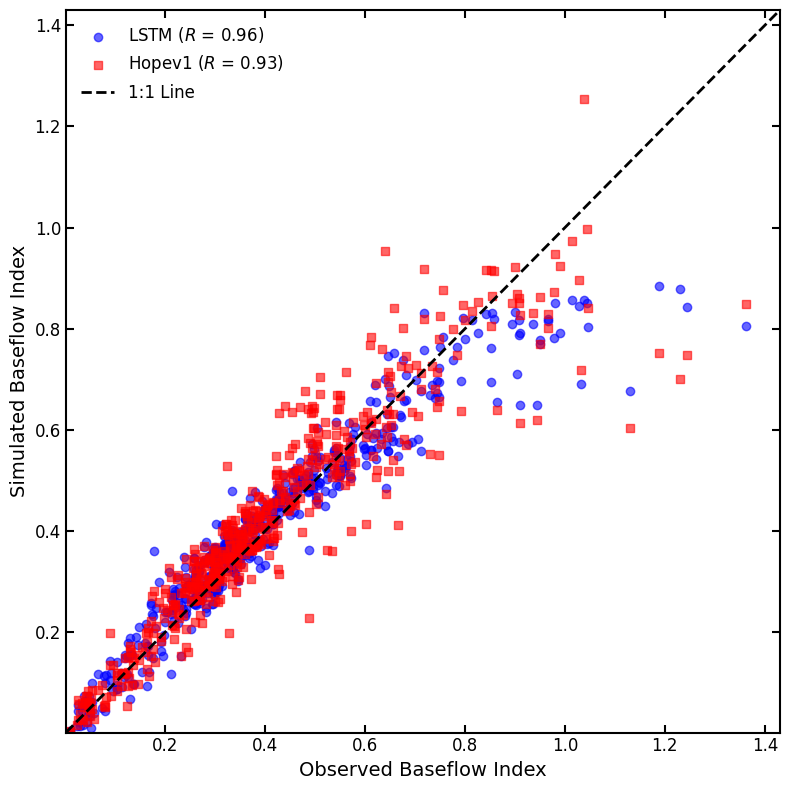

In [32]:
plot_baseflow_scatter(
    real_runoff_ratio,
    runoff_ratio_lstm,
    runoff_ratio_hopev1,
)